<a href="https://colab.research.google.com/github/tusker4/Sesac_Saltlux_Team5/blob/JunleeSon/%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80_%EC%8B%A4%EC%8A%B5_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [487]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터셋
- CementComponent: 콘크리트에 혼합된 시멘트 밀도
- BlastFurnaceSlag: 콘크리트에 혼합된 고로슬래그 밀도
- FlyAshComponent: 콘크리트에 혼합된 플라이애쉬 밀도
- WaterComponent: 콘크리트에 혼합된 물의 밀도
- SuperplasticizerComponent: 콘크리트에 혼합된 고성능 플라스티서 밀도
- CoarseAggregateComponent: 콘크리트에 혼합된 거친 골재 밀도
- FineAggregateComponent: 콘크리트에 혼합된 미세 골재 밀도
- AgeInDays: 콘크리트가 건조한 일 수
- Strength: 콘크리트의 최종 강도(Target)

# 데이터 준비

In [488]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/SeSAC/share/머신러닝/Dataset/Concrete Dataset/train.csv', index_col='id')
test  = pd.read_csv('/content/drive/MyDrive/SeSAC/share/머신러닝/Dataset/Concrete Dataset/test.csv', index_col='id')
submission = pd.read_csv('/content/drive/MyDrive/SeSAC/share/머신러닝/Dataset/Concrete Dataset/sample_submission.csv')

target = 'Strength'

train.shape, test.shape, submission.shape

((5407, 9), (3605, 8), (3605, 2))

In [489]:
# 피처 확인
print( train.columns )
print( test.columns )
# test 데이터에서 'Strength' 누락
print( submission.columns )

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')
Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'],
      dtype='object')
Index(['id', 'Strength'], dtype='object')


In [490]:
train.head(2)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52


# 모델구축-베이스라인

## 피쳐엔지니어링

### 데이터 합치기

In [491]:
train.shape, test.shape

# 2개를 합치면 반드시 결측치가 발생(피처수가 달라서)
# 차후 다시 분해할때는 결측을 기준으로 분해

((5407, 9), (3605, 8))

In [492]:
# 데이터가 늘어나는 구조 => axis=0으로, 1차원으로, 수직으로 합병
# 원데이터 인덱스 무시 : ignore_index
train_test_df = pd.concat( [train, test], ignore_index=True )

train_test_df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,NaN
9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,NaN
9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,NaN
9010,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,NaN


In [493]:
train_test_df['clippedWater'] = train_test_df.WaterComponent.clip(160, None)
train_test_df['clippedAge'] = train_test_df.AgeInDays.clip(None, 40)

In [494]:
train_test_df['hasBlastFurnaceSlag'] = train_test_df.BlastFurnaceSlag != 0
train_test_df['hasFlyAshComponent'] = train_test_df.FlyAshComponent != 0
train_test_df['hasSuperplasticizerComponent'] = train_test_df.SuperplasticizerComponent != 0

In [495]:
train_test_df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,clippedWater,clippedAge,hasBlastFurnaceSlag,hasFlyAshComponent,hasSuperplasticizerComponent
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,186.0,3,False,False,False
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,191.0,28,True,True,True
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,185.7,28,True,False,False
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,228.0,40,True,False,False
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,192.0,40,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,NaN,200.0,28,True,True,True
9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,NaN,186.0,28,False,False,False
9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,NaN,194.0,28,True,False,True
9010,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,NaN,160.0,3,True,False,True


In [496]:
train_test_df = train_test_df.drop([ 'WaterComponent', 'AgeInDays', 'BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent', ], axis=1)

In [497]:
train_test_df

,CementComponent,CoarseAggregateComponent,FineAggregateComponent,Strength,clippedWater,clippedAge,hasBlastFurnaceSlag,hasFlyAshComponent,hasSuperplasticizerComponent
0,525.0,1125.0,613.0,10.38,186.0,3,False,False,False
1,143.0,967.0,643.0,23.52,191.0,28,True,True,True
2,289.0,1075.0,795.3,36.96,185.7,28,True,False,False
3,304.0,932.0,670.0,39.05,228.0,40,True,False,False
4,157.0,935.4,781.2,74.19,192.0,40,True,False,False
...,...,...,...,...,...,...,...,...,...
9007,140.0,864.0,753.0,NaN,200.0,28,True,True,True
9008,281.0,1104.0,774.0,NaN,186.0,28,False,False,False
9009,289.0,924.0,760.0,NaN,194.0,28,True,False,True
9010,469.0,852.1,840.5,NaN,160.0,3,True,False,True


In [498]:
# 결측은 정답만 존재(테스트데이터), 모든 데이터는 수치화
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9012 entries, 0 to 9011
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CementComponent               9012 non-null   float64
 1   CoarseAggregateComponent      9012 non-null   float64
 2   FineAggregateComponent        9012 non-null   float64
 3   Strength                      5407 non-null   float64
 4   clippedWater                  9012 non-null   float64
 5   clippedAge                    9012 non-null   int64  
 6   hasBlastFurnaceSlag           9012 non-null   bool   
 7   hasFlyAshComponent            9012 non-null   bool   
 8   hasSuperplasticizerComponent  9012 non-null   bool   
dtypes: bool(3), float64(5), int64(1)
memory usage: 449.0 KB


### 데이터 나누기 및 학습데이터 준비

In [499]:
X_sub = train_test_df[ pd.isnull( train_test_df['Strength'] ) ] # 테스트용, submission용
X_sub.shape

(3605, 9)

In [500]:
X_sub

,CementComponent,CoarseAggregateComponent,FineAggregateComponent,Strength,clippedWater,clippedAge,hasBlastFurnaceSlag,hasFlyAshComponent,hasSuperplasticizerComponent
5407,166.1,1007.2,746.6,NaN,173.8,40,True,True,True
5408,304.0,998.0,801.0,NaN,190.0,7,False,False,False
5409,225.0,1113.0,833.0,NaN,185.0,28,False,False,False
5410,251.4,1028.4,757.7,NaN,188.5,40,False,True,True
5411,144.0,1021.0,709.0,NaN,176.0,28,True,True,True
...,...,...,...,...,...,...,...,...,...
9007,140.0,864.0,753.0,NaN,200.0,28,True,True,True
9008,281.0,1104.0,774.0,NaN,186.0,28,False,False,False
9009,289.0,924.0,760.0,NaN,194.0,28,True,False,True
9010,469.0,852.1,840.5,NaN,160.0,3,True,False,True


In [501]:
# 훈련용
X = train_test_df[ ~pd.isnull( train_test_df['Strength'] ) ]
X.shape

(5407, 9)

In [502]:
# 훈련용 데이터 준비
y = X['Strength']
X = X.drop( ['Strength'], axis=1 )
# submission용 데이터 준비
X_sub = X_sub.drop( ['Strength'], axis=1 )

X.shape, X_sub.shape, y.shape

((5407, 8), (3605, 8), (5407,))

In [503]:
# 학습에 사용되는 훈련용, 테스트용 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4055, 8), (1352, 8), (4055,), (1352,))

## 평가지표 커스텀 함수 생성

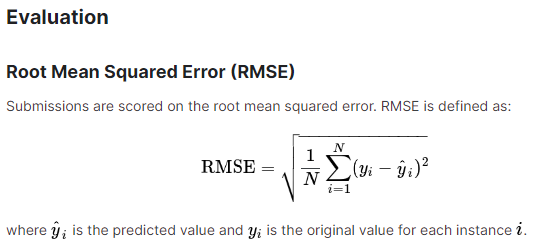

In [504]:
from IPython.display import Image
Image('/content/drive/MyDrive/SeSAC/share/머신러닝/reg/ml_rmse_식.png')

# RMSE는 실제값과 예측값 간의 거리를 나타내는 지표로, 값이 작을수록 모델이 더 정확하게 예측

## AutoML - 파이캐럿

In [505]:
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install -q pycaret
!pip install fastapi python-multipart uvicorn
!pip install --upgrade lida
!pip install --upgrade scipy

  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.1.0 requires scipy~=1.10.1, but you have scipy 1.11.3 which is incompatible.


### 데이터 풀구성
- 캐글에서만 해볼 수 있는 치트키

In [506]:
X = pd.concat( [X_train, X_test] )
y = pd.concat( [y_train, y_test] )

X.shape, y.shape

((5407, 8), (5407,))

### 모듈 가져오

In [507]:
from pycaret.regression import *

### setup

In [508]:
reg = setup( data=X,
             target= y,
             verbose=True,
             train_size=0.75,
             data_split_shuffle=True,
             normalize=True,
             session_id=100)

,Description,Value
0,Session id,100
1,Target,Strength
2,Target type,Regression
3,Original data shape,"(5407, 9)"
4,Transformed data shape,"(5407, 9)"
5,Transformed train set shape,"(4055, 9)"
6,Transformed test set shape,"(1352, 9)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [509]:
# models()

### top6 후보

In [510]:
top10_models = compare_models( fold=5, round=3, n_select=10, errors='ignore')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,9.456,150.153,12.248,0.444,0.383,0.362,0.530
lr,Linear Regression,9.553,152.663,12.351,0.435,0.387,0.368,1.820
ridge,Ridge Regression,9.553,152.662,12.351,0.435,0.387,0.368,0.088
lar,Least Angle Regression,9.553,152.663,12.351,0.435,0.387,0.368,0.080
br,Bayesian Ridge,9.554,152.658,12.351,0.435,0.387,0.369,0.060
huber,Huber Regressor,9.456,153.777,12.396,0.430,0.383,0.353,0.060
catboost,CatBoost Regressor,9.640,157.148,12.527,0.419,0.391,0.365,2.762
llar,Lasso Least Angle Regression,9.833,157.336,12.539,0.417,0.398,0.389,0.074
lasso,Lasso Regression,9.833,157.336,12.539,0.417,0.398,0.389,0.088
lightgbm,Light Gradient Boosting Machine,9.681,158.296,12.573,0.414,0.391,0.364,0.388


Processing:   0%|          | 0/94 [00:00<?, ?it/s]

### top 10 알고리즘 확인

In [511]:
top10_models

[GradientBoostingRegressor(random_state=100),
 LinearRegression(n_jobs=-1),
 Ridge(random_state=100),
 Lars(random_state=100),
 BayesianRidge(),
 HuberRegressor(),
 LassoLars(random_state=100),
 Lasso(random_state=100),
 LGBMRegressor(n_jobs=-1, random_state=100)]

### 블랜딩

In [512]:
reg_blended = blend_models(estimator_list=top10_models, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.3046,143.5048,11.9793,0.4419,0.3743,0.3546
1,9.5151,150.8504,12.2821,0.4719,0.3900,0.3814
2,9.7694,154.0141,12.4102,0.4127,0.4001,0.3870
3,9.0334,136.5398,11.6850,0.4758,0.3778,0.3602
4,9.6567,162.5750,12.7505,0.4298,0.3767,0.3408
Mean,9.4558,149.4968,12.2214,0.4464,0.3838,0.3648
Std,0.2621,8.9114,0.3648,0.0243,0.0098,0.0171


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 최종모델

In [513]:
model = finalize_model( reg_blended )
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['CementComponent',
                                             'CoarseAggregateComponent',
                                             'FineAggregateComponent',
                                             'clippedWater', 'clippedAge'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', Transfo...
                                              Lars(random_state=100)),
                                             ('Bayesian Ridge',
                                              BayesianRidge()),
                                             ('Huber Regressor',
                                              HuberRegressor()),
                                             ('CatBoost Regressor',
                                              <catboost.core.CatBoostRegressor object at 0x7fad3d2ba5c0>),
                                             ('Lasso Least Angle Regression',
                                              LassoLars(random_state=100)),
                                             ('Lasso Regression',
                                              Lasso(random_state=100)),
                                             ('Light Gradient Boosting Machine',
                                              LGBMRegressor(n_jobs=-1,
                                                            random_state=100))],
                                 n_jobs=-1))])

### 검증모델

In [514]:
predict_model( model )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,8.9319,134.7245,11.6071,0.4904,0.3707,0.3498


,CementComponent,CoarseAggregateComponent,FineAggregateComponent,clippedWater,clippedAge,hasBlastFurnaceSlag,hasFlyAshComponent,hasSuperplasticizerComponent,Strength,prediction_label
1236,425.000000,852.099976,887.099976,160.000000,40,True,False,True,66.820000,56.890089
1149,310.000000,1012.000000,830.000000,192.000000,7,False,False,False,17.219999,19.653331
634,350.000000,974.000000,775.000000,203.000000,14,False,False,False,27.680000,25.238130
2579,144.000000,878.000000,728.000000,212.000000,28,True,True,True,29.230000,34.174458
3576,200.000000,965.400024,806.200012,192.000000,28,True,False,False,26.059999,34.147722
...,...,...,...,...,...,...,...,...,...,...
724,139.600006,1047.000000,806.900024,192.000000,3,True,False,False,27.940001,14.936785
215,540.000000,1125.000000,613.000000,173.000000,14,False,False,False,15.520000,30.727765
1018,218.199997,1075.699951,792.700012,160.000000,40,True,True,True,57.209999,49.040901
1005,166.800003,867.200012,611.799988,175.500000,28,True,True,True,23.639999,34.936056


In [515]:
from sklearn.metrics import mean_squared_error

# 예측
y_pred = model.predict( X_test )
# 평가

# rmse
rmse = np.sqrt( mean_squared_error( y_test, y_pred ) )

rmse

11.421737148189987

### submission 제출

In [516]:
sub_y_pred = predict_model( model, data = X_sub)
submission['Strength'] = sub_y_pred.prediction_label.values
submission.to_csv('submission_v7.csv', index=False)

# 12.25668 -> 16등